<a target="_blank" href="https://colab.research.google.com/github/impresso/impresso-datalab-notebooks/blob/main/workshop_resources/ws4-embeddings/EventDetectionGranularity.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Granularity, Events and Embeddings

This notebooks provides basic functionality for embedding texts at different levels, from the whole article to chunks and headlines. The main purpose is to showcase the retrieval and embedding functionalities of the Impresso API, as well as provide some code for visualising embeddings using dimensionality reduction.

## Install required packages

In [1]:
!pip -qqq install pandas chonkie faiss-cpu tqdm seaborn plotly umap-learn

In [2]:
!pip -qqq install git+https://github.com/impresso/impresso-py.git@embeddings-search

In [3]:
# # restart the kernel just in case...
# import os
# os.kill(os.getpid(), 9)

## Load and process data

In [2]:
!pip install gdown

In [1]:
!gdown 1H8_1-PbGPlcrm3wvwd1xGaUrhNnYETha

Downloading...
From: https://drive.google.com/uc?id=1H8_1-PbGPlcrm3wvwd1xGaUrhNnYETha
To: /Users/eboros/projects/4_impresso/impresso-datalab-notebooks/workshop_resources/ws4-embeddings/Olympics-general.zip
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 21.2M/21.2M [00:00<00:00, 27.1MB/s]


In [4]:
# unzip the data for the general query
!unzip -o Olympics-general.zip -d data

Archive:  Olympics-general.zip
  inflating: data/2025-10-20T13-28-55-45260b95.csv  


In [1]:
import os
import pandas as pd
from chonkie import SemanticChunker
from tqdm import tqdm
import faiss
import numpy as np
from impresso import connect

## Connect to the Impresso client

In [147]:
impresso_session = connect('https://dev.impresso-project.ch/public-api/v1')


Click on the following link to access the login page: https://dev.impresso-project.ch/datalab/token
 - üî§ Enter your email/password on this page.
 - üîë Once logged in, a secret token will be generated for you.
 - üìã Copy this token and paste it into the input field below. Then press "Enter". üëáüèº.



üîë Enter your token:  ¬∑¬∑¬∑¬∑¬∑¬∑¬∑¬∑


üéâ You are now connected to the Impresso API!  üéâ
üîó Using API: https://dev.impresso-project.ch/public-api/v1


## Load helper functions

In [3]:
# embed text helper functions
import time
import base64
import struct

def embed_text(text: str, target: str):
  """
  Convert text to embedding, return None in case of an error
  """
  # time.sleep(1)
  try:
    return impresso_session.tools.embed_text(text, target)
  except Exception as e:
    print(text)
    print(e)
    return None


def convert_embedding(embedding: np.float32):
  """
  Convert base64 string to a float array
  """
  if not embedding:
    return None

  _, arr = embedding.split(':')
  arr = base64.b64decode(arr)
  outof_corpus_emb = [struct.unpack('f', arr[i:i+4])[0] for i in range(0, len(arr), 4)]
  return outof_corpus_emb

## Load data

The data file is csv document containing articles mentioning "Olympic Games"

In [5]:
# --- CONFIG ---
CSV_PATH = "data/2025-10-20T13-28-55-45260b95.csv"         # Path to your CSV file


In [6]:
df = pd.read_csv(CSV_PATH, sep=';',skiprows=4)
df.head(3)

uid  access_right collections countryCode  \
0  BNN-1886-02-09-a-i0002           NaN         NaN          CH   
1  BNN-1889-05-21-a-i0027           NaN         NaN          CH   
2  BNN-1891-09-06-a-i0034           NaN         NaN          CH   

  dataProviderCode                                            excerpt  \
0              SNL  Allerlei Notizen ‚Äî In der italienischen Gemein...   
1              SNL  n Das Turnen itt der Volksschule Als das Turne...   
2              SNL  Iugendspiele Immer lebhafter, so schreiben die...   

   isOnFrontPage  is_content_available  is_olr             issue  ...  \
0          False                   NaN    True  BNN-1886-02-09-a  ...   
1           True                   NaN    True  BNN-1889-05-21-a  ...   
2           True                   NaN    True  BNN-1891-09-06-a  ...   

  provinceCode       publicationDate relevance  \
0           GR  1886-02-09T00:00:00Z  4.885939   
1           GR  1889-05-21T00:00:00Z  2.840050   
2           GR  1891-09-06T00:00:00Z  2.208386   

                              title  \
0                  Allerlei Notizen   
1  n Das Turnen itt der Volksschule   
2                      Iugendspiele   

                                              topics totalPages  \
0  tm-de-all-v2.0_tp47_de|0.298 tm-de-all-v2.0_tp...          1   
1  tm-de-all-v2.0_tp30_de|0.395 tm-de-all-v2.0_tp...          1   
2  tm-de-all-v2.0_tp92_de|0.175 tm-de-all-v2.0_tp...          1   

                                          transcript transcriptLength type  \
0  Allerlei Notizen ‚Äî In der italienischen Gemein...              219   ar   
1  n Das Turnen itt der Volksschule Als das Turne...             1204   ar   
2  Iugendspiele Immer lebhafter, so schreiben die...             1655   ar   

   year  
0  1886  
1  1889  
2  1891  

[3 rows x 29 columns]

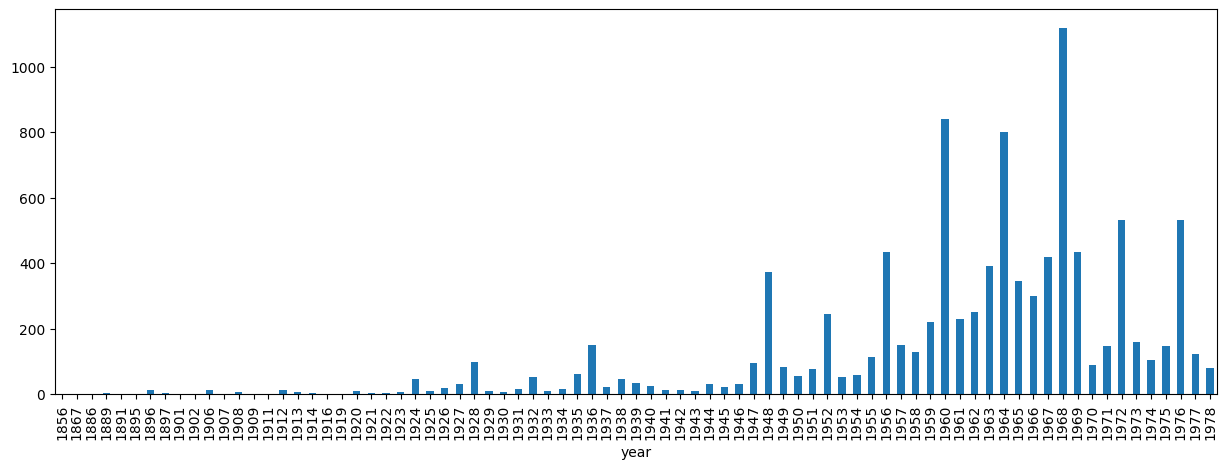

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))  # increase width (15) and height (5)
_ = df['year'].value_counts().sort_index().plot(kind='bar')
plt.show()

In [17]:
df.columns

Index(['uid', 'access_right', 'collections', 'countryCode', 'dataProviderCode',
       'excerpt', 'isOnFrontPage', 'is_content_available', 'is_olr', 'issue',
       'languageCode', 'locations_mentioned', 'mediaCode',
       'mediaPoliticalOrientation', 'mediaTopics', 'newsagencies_mentioned',
       'pages', 'periodicity', 'persons_mentioned', 'provinceCode',
       'publicationDate', 'relevance', 'title', 'topics', 'totalPages',
       'transcript', 'transcriptLength', 'type', 'year'],
      dtype='object')

In [8]:
#¬†to reduce the data a bit let's focus on the 30s and 40?
df_period = df[df.year.between(1930, 1950) & ~(df['title'].isnull())]
df_period.shape

(1137, 29)

In [21]:
df_period.excerpt.unique()

array(['MOMMOMLM von Woche zu Woche. Deutschland und Italien haben die Einladung zur Teil ¬ª nahm ¬´ an der neuen Locarnolonferenz angenommen. Deutschland hat k',
       'Reorganisation im Sportbetriebt Mit der Veendigung der Olympischen Spiele in Verlin ist es lim die Frage der Reorganisation der Sportbewegung wieder l',
       'allen gnten Geistern verlassen, soweit gebracht, da√ü die Abwcrtnng noch als einziges Allheilmittel verblieb. Und nun? Ende September sprach der Ehef d',
       ...,
       "L'assembl√©e g√©n√©rale de la Soci√©t√© f√©d√©rale de gymnastique Samedi s est r√©unie √† Gen√®ve, en pr√©sence de quelque 300 d√©l√©gu√©s et invit√©s, l'assembl√©e g",
       "Les grands anniversaires d'octobre (SUITE l > i ; I. A PREMIER *; PAOE) Mais le voyageur canadien ne s'en tint pas l√† ; avant de mourir, le 18 oct obr",
       "Rencontres internationales S'il est deux sports qui attirent les foules ce sont bien le football et le hockey sur glace. Aussi demain, les amateurs de"],
 

In [63]:
df_period

uid  access_right  collections countryCode  \
4     DTT-1936-08-05-a-i0029           NaN          NaN          CH   
5     DTT-1936-11-04-a-i0010           NaN          NaN          CH   
6     DTT-1936-11-18-a-i0007           NaN          NaN          CH   
7     DTT-1938-10-07-a-i0041           NaN          NaN          CH   
8     DTT-1939-05-19-a-i0028           NaN          NaN          CH   
...                      ...           ...          ...         ...   
5711  EXP-1950-07-31-a-i0069           NaN          NaN          CH   
5712  EXP-1950-09-06-a-i0209           NaN          NaN          CH   
5713  EXP-1950-10-16-a-i0058           NaN          NaN          CH   
5714  EXP-1950-10-17-a-i0094           NaN          NaN          CH   
5715  EXP-1950-11-11-a-i0102           NaN          NaN          CH   

     dataProviderCode                                            excerpt  \
4              Migros  MOMMOMLM von Woche zu Woche. Deutschland und I...   
5              Migros  Reorganisation im Sportbetriebt Mit der Veendi...   
6              Migros  allen gnten Geistern verlassen, soweit gebrach...   
7              Migros  v ¬´ r Iv 1 ill ¬ª_ rsllofe! ls ¬ª ¬´ l ¬´ l ¬´ r zu...   
8              Migros  inen Dokumentarfilm diesem Film die sch√∂ne, √ºb...   
...               ...                                                ...   
5711              SNL  Les athl√®tes militaires d√©montrent Samedi et d...   
5712              SNL  SAINT-AUBIN F√™te sportive de l '¬´ _Helv√©tia ¬ª ...   
5713              SNL  L'assembl√©e g√©n√©rale de la Soci√©t√© f√©d√©rale de...   
5714              SNL  Les grands anniversaires d'octobre (SUITE l > ...   
5715              SNL  Rencontres internationales S'il est deux sport...   

      isOnFrontPage  is_content_available  is_olr             issue  ...  \
4             False                   NaN    True  DTT-1936-08-05-a  ...   
5             False                   NaN    True  DTT-1936-11-04-a  ...   
6             False                   NaN    True  DTT-1936-11-18-a  ...   
7             False                   NaN    True  DTT-1938-10-07-a  ...   
8             False                   NaN    True  DTT-1939-05-19-a  ...   
...             ...                   ...     ...               ...  ...   
5711          False                   NaN    True  EXP-1950-07-31-a  ...   
5712          False                   NaN    True  EXP-1950-09-06-a  ...   
5713          False                   NaN    True  EXP-1950-10-16-a  ...   
5714          False                   NaN    True  EXP-1950-10-17-a  ...   
5715          False                   NaN    True  EXP-1950-11-11-a  ...   

     totalPages                                         transcript  \
4             1  MOMMOMLM von Woche zu Woche. Deutschland und I...   
5             1  Reorganisation im Sportbetriebt Mit der Veendi...   
6             1  allen gnten Geistern verlassen, soweit gebrach...   
7             1  v ¬´ r Iv 1 ill ¬ª_ rsllofe! ls ¬ª ¬´ l ¬´ l ¬´ r zu...   
8             1  inen Dokumentarfilm diesem Film die sch√∂ne, √ºb...   
...         ...                                                ...   
5711          1  Les athl√®tes militaires d√©montrent Samedi et d...   
5712          1  SAINT-AUBIN F√™te sportive de l '¬´ _Helv√©tia ¬ª ...   
5713          1  L'assembl√©e g√©n√©rale de la Soci√©t√© f√©d√©rale de...   
5714          1  Les grands anniversaires d'octobre (SUITE l > ...   
5715          1  Rencontres internationales S'il est deux sport...   

     transcriptLength type  year  \
4                 302   ar  1936   
5                 987   ar  1936   
6                1173   ar  1936   
7                 407   ar  1938   
8                 925   ar  1939   
...               ...  ...   ...   
5711             1549   ar  1950   
5712              333   ar  1950   
5713              458   ar  1950   
5714              664   ar  1950   
5715              410   ar  1950   

                              

## Embed Headlines

In [22]:
tqdm.pandas()
df_period['excerpt_embedding'] = df_period['excerpt'].progress_apply(
    lambda x: convert_embedding(embed_text(x, 'text')))

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1137/1137 [05:37<00:00,  3.37it/s]


In [23]:
#¬†let's first get the embeddings of the transcript title and look

tqdm.pandas()
df_period['title_embedding'] = df_period['title'].progress_apply(
    lambda x: convert_embedding(embed_text(x, 'text')))

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1137/1137 [05:32<00:00,  3.42it/s]


## Retrieve transcript embeddings

In [26]:
# get the article embeddings from the API

def get_embedding_by_uid(uid):
  time.sleep(1)
  try:
    return convert_embedding(impresso_session.content_items.get_embeddings(uid)[0])
  except Exception as e:
    # print(e)
    # print(uid)
    pass
    return None

df_period['article_embedding']  = df_period.uid.progress_apply(get_embedding_by_uid)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1137/1137 [21:03<00:00,  1.11s/it]


In [75]:
sentence = "winterspiele"



## Save data

In [26]:
df_period.to_json('olympic-general-embedded.json')

## Plot Embeddings with UMAP

Plot either transcript (i.e. article) or headline (i.e. title) embeddings with dimensionality reduction.

In [37]:
!gdown 18SyEXcXjRTyu3UOzDOFZdDb16jA2ejmM

Downloading...
From: https://drive.google.com/uc?id=18SyEXcXjRTyu3UOzDOFZdDb16jA2ejmM
To: /Users/eboros/projects/4_impresso/impresso-datalab-notebooks/workshop_resources/ws4-embeddings/olympic-general-embedded.json
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 29.1M/29.1M [00:01<00:00, 27.8MB/s]


In [77]:
df_period = pd.read_json('olympic-general-embedded.json')

len(df_period)

1137

In [78]:
df_period = df_period.dropna(subset=['article_embedding'])

In [ ]:
# --- DIMENSIONALITY REDUCTION ---
from umap import UMAP
print("Reducing to 2D with UMAP...")
reducer = UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=42
)

EMBEDDING = 'article_embedding' # 'title_embedding' | 'article_embedding'

df_period = pd.read_json('olympic-general-embedded.json')

df_period = df_period[~df_period[EMBEDDING].isnull()]

embeddings = list(df_period[EMBEDDING])
embeddings_2d = reducer.fit_transform(embeddings)

df_period["x"] = embeddings_2d[:, 0]
df_period["y"] = embeddings_2d[:, 1]

Reducing to 2D with UMAP...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [79]:
EMBEDDING = 'article_embedding' # 'title_embedding' | 'article_embedding'


In [80]:
len(df_period)


1002

In [81]:
for x in df_period["article_embedding"]:
    if x is None:
        print(x)

In [82]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X = np.vstack(df_period["article_embedding"].values)
kmeans = KMeans(n_clusters=5, random_state=42)
df_period["cluster"] = kmeans.fit_predict(X)


In [83]:
from collections import Counter

for cluster_id in sorted(df_period["cluster"].unique()):
    subset = df_period[df_period["cluster"] == cluster_id]
    # print(subset)
    # top_occupations = Counter(subset["occupation"]).most_common(3)
    
    # print(f"\nüü© Cluster {cluster_id}  ‚Äî  size: {len(subset)}")
    # print("Top occupations:", [occ for occ, _ in top_occupations])
    # print("Sample entities:")
    
    for _, row in subset.sample(min(5, len(subset)), random_state=42).iterrows():
        print(f"   ‚Ä¢ {row['transcript'][:10]}... ‚Äî {row['transcriptLength']}")
    #     print(f"     {row['wiki_url_s']}")

   ‚Ä¢ J >* H Ift... ‚Äî 1689
   ‚Ä¢ Sport-Vors... ‚Äî 1188
   ‚Ä¢ Internatio... ‚Äî 1847
   ‚Ä¢ Mannschaft... ‚Äî 1079
   ‚Ä¢ _TlauueUes... ‚Äî 574
   ‚Ä¢ alles gut;... ‚Äî 312
   ‚Ä¢ Le congr√®s... ‚Äî 521
   ‚Ä¢ La s√©ance ... ‚Äî 262
   ‚Ä¢ L'assembl√©... ‚Äî 340
   ‚Ä¢ ¬´ Die Schw... ‚Äî 326
   ‚Ä¢ HERMi & m ... ‚Äî 151
   ‚Ä¢ Les Jeux o... ‚Äî 464
   ‚Ä¢ nicht, son... ‚Äî 318
   ‚Ä¢ Aux Jeux o... ‚Äî 2417
   ‚Ä¢ Olympische... ‚Äî 2916
   ‚Ä¢ Im Kunstha... ‚Äî 1507
   ‚Ä¢ Deutschlan... ‚Äî 279
   ‚Ä¢ John Lewis... ‚Äî 2358
   ‚Ä¢ La p√©nurie... ‚Äî 242
   ‚Ä¢ Neuch√¢tel-... ‚Äî 387
   ‚Ä¢ ^ l ^ o ra... ‚Äî 314
   ‚Ä¢ ^ L ^ ora ... ‚Äî 577
   ‚Ä¢ Emissions ... ‚Äî 294
   ‚Ä¢ Emissions ... ‚Äî 506
   ‚Ä¢ Emissions ... ‚Äî 518


In [84]:
tsne = TSNE(n_components=2, perplexity=35, random_state=42)
X_2d = tsne.fit_transform(X)
df_period["x"], df_period["y"] = X_2d[:, 0], X_2d[:, 1]

Text(0, 0.5, 't-SNE 2')

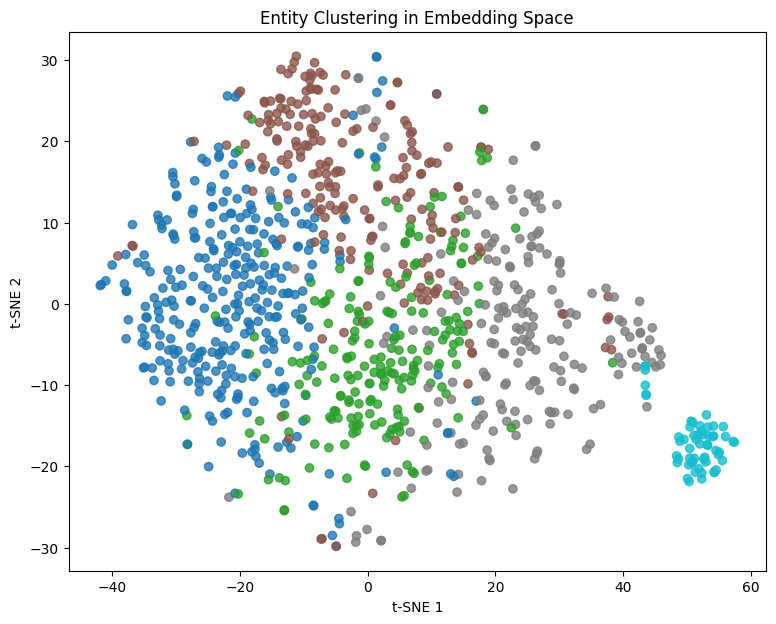

In [85]:
plt.figure(figsize=(9, 7))
scatter = plt.scatter(df_period["x"], df_period["y"], c=df_period["cluster"], cmap="tab10", alpha=0.8)
plt.title("Entity Clustering in Embedding Space")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")


In [87]:
df_period.columns
df_period.head(1)

uid  access_right  collections countryCode  \
4  DTT-1936-08-05-a-i0029           NaN          NaN          CH   

  dataProviderCode                                            excerpt  \
4           Migros  MOMMOMLM von Woche zu Woche. Deutschland und I...   

   isOnFrontPage  is_content_available  is_olr             issue  ...  \
4          False                   NaN    True  DTT-1936-08-05-a  ...   

  totalPages                                         transcript  \
4          1  MOMMOMLM von Woche zu Woche. Deutschland und I...   

  transcriptLength type  year  \
4              302   ar  1936   

                                     title_embedding  \
4  [-0.028241433200000002, 0.0498822145, -0.03026...   

                                   article_embedding cluster          x  \
4  [-0.0446898863, 0.0711098164, -0.076359801, 0....       3  20.456684   

          y  
4  2.278999  

[1 rows x 34 columns]

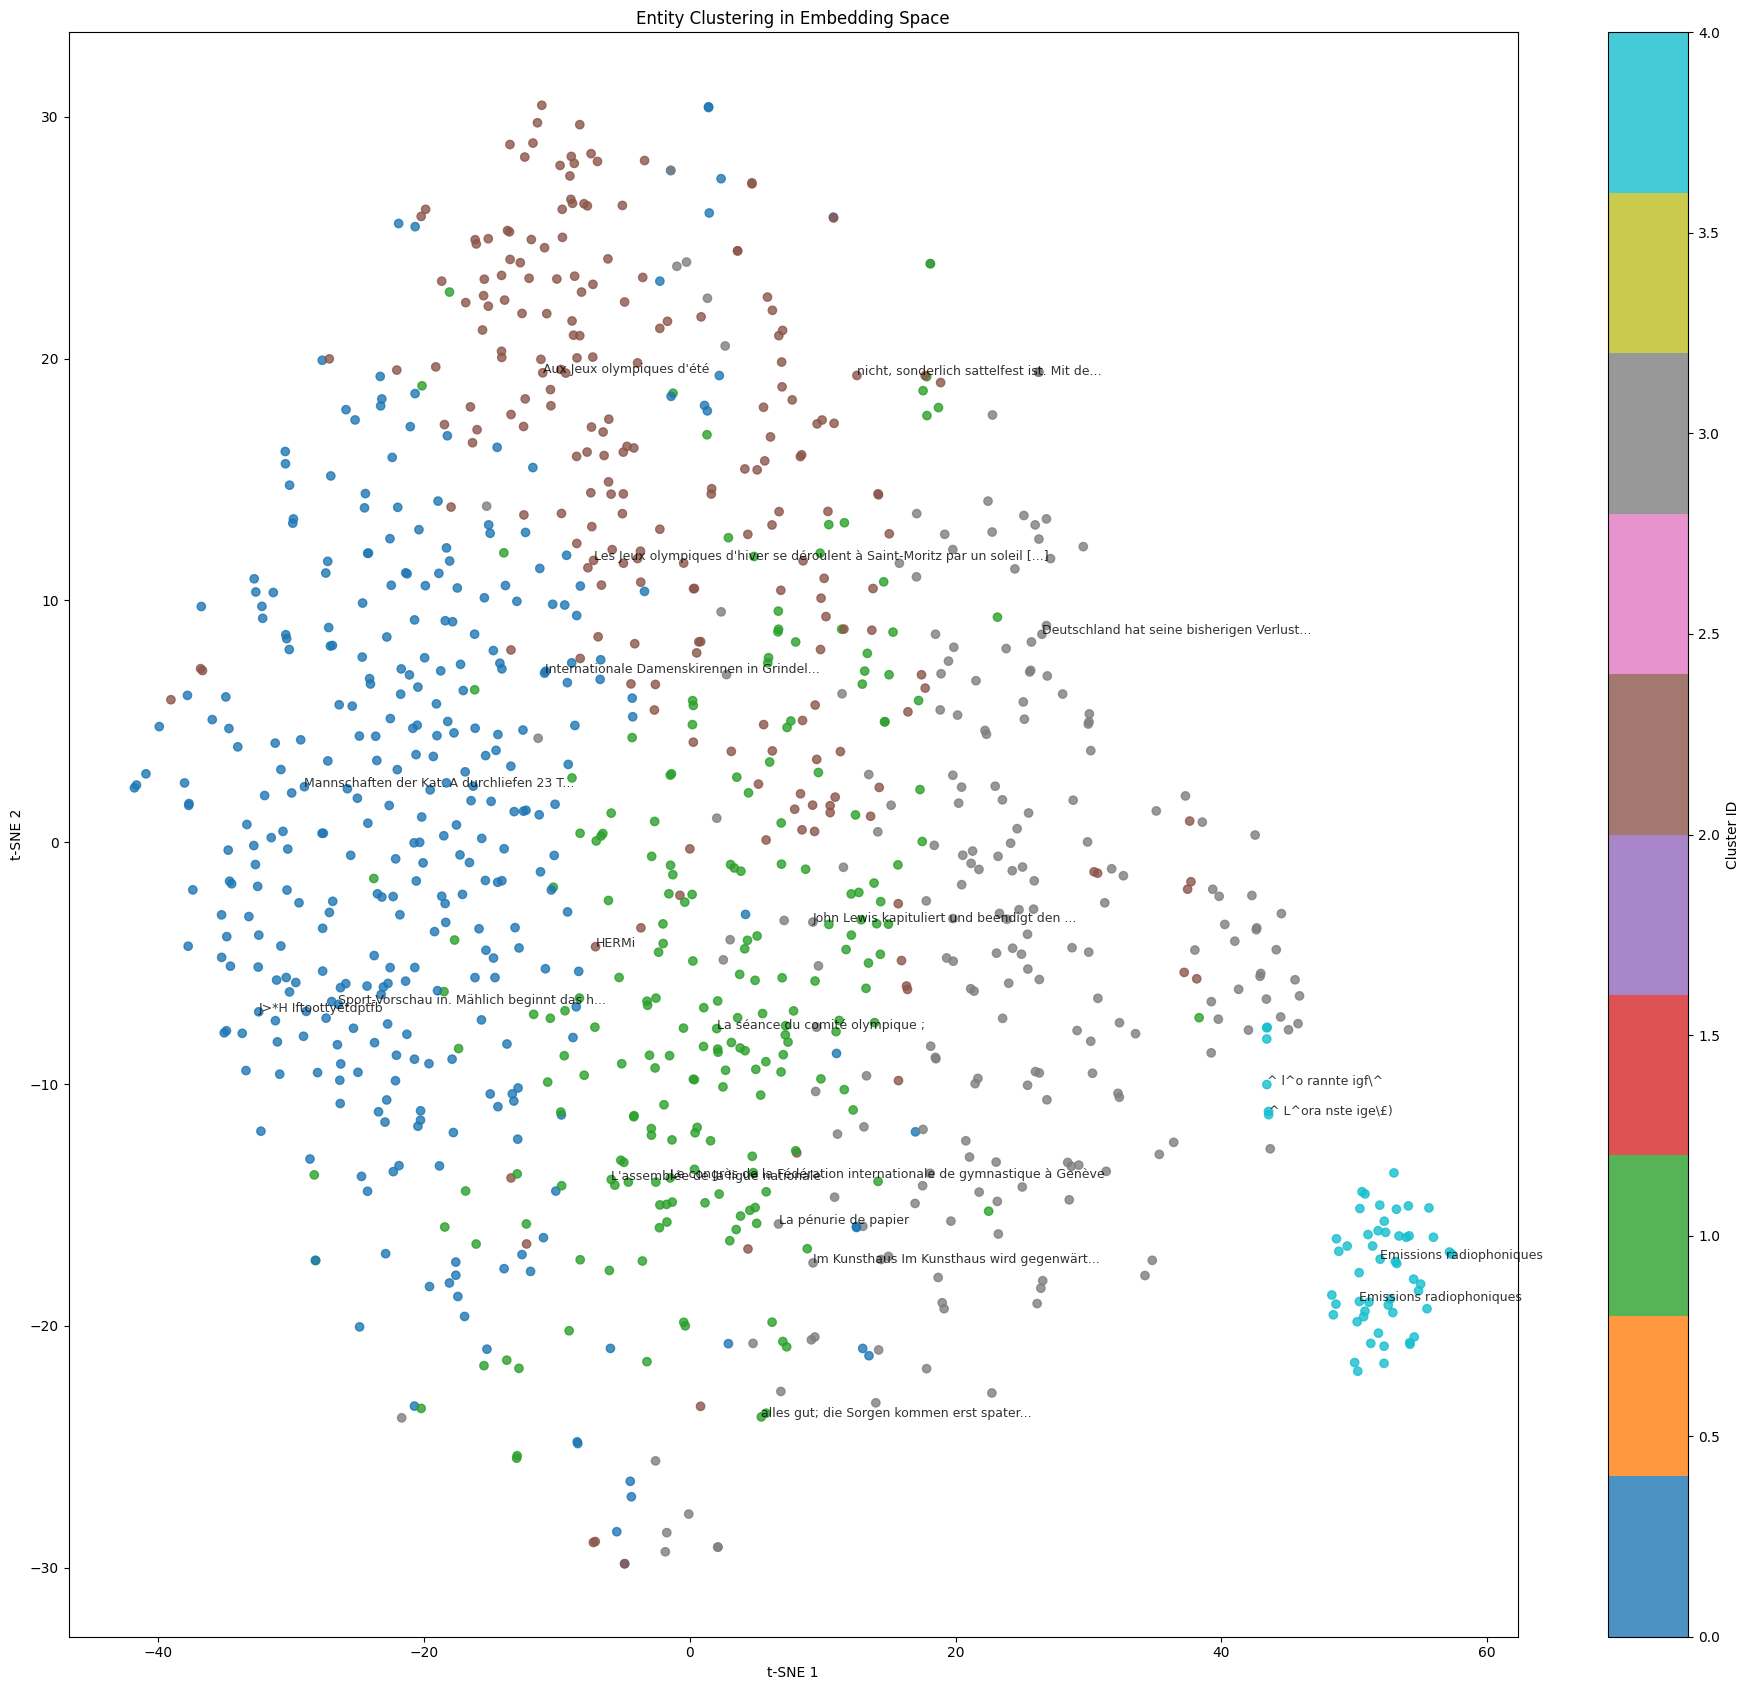

In [88]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(19, 17))
scatter = plt.scatter(df_period["x"], df_period["y"], c=df_period["cluster"], cmap="tab10", alpha=0.8)
plt.title("Entity Clustering in Embedding Space")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

for cluster_id in df_period["cluster"].unique():
    sample = df_period[df_period["cluster"] == cluster_id].sample(4, random_state=42)
    for _, row in sample.iterrows():
        plt.text(row["x"], row["y"], row["title"], fontsize=9, alpha=0.8)

# Option 2 (alternative): label a few well-known or random ones
# for _, row in df.sample(15, random_state=0).iterrows():
#     plt.text(row["x"], row["y"], row["name"], fontsize=8, alpha=0.7)

plt.colorbar(scatter, label="Cluster ID")
plt.tight_layout()
plt.show()

In [69]:
df_period.columns

Index(['uid', 'access_right', 'collections', 'countryCode', 'dataProviderCode',
       'excerpt', 'isOnFrontPage', 'is_content_available', 'is_olr', 'issue',
       'languageCode', 'locations_mentioned', 'mediaCode',
       'mediaPoliticalOrientation', 'mediaTopics', 'newsagencies_mentioned',
       'pages', 'periodicity', 'persons_mentioned', 'provinceCode',
       'publicationDate', 'relevance', 'title', 'topics', 'totalPages',
       'transcript', 'transcriptLength', 'type', 'year', 'title_embedding',
       'article_embedding', 'cluster', 'x', 'y'],
      dtype='object')

In [70]:
df_period.locations_mentioned

4                                 Italien|Berlin|N√ºrnberg
5                                                  Verlin
6       St. Gallen|Schweiz|Oesterreich|England|Vereini...
7       Bitler|Deutschland|Mitteleuropa|Tokio|Fernen O...
8                                         Schwyz|Helsinki
                              ...                        
5711    Neuch√¢tei|Neuch√¢tei|Berne|Berne|Berne|Berne|Be...
5712                  Londres|rues de Saint-Aubin|Yverdon
5713             Gen√®ve|Gen√®ve|Lausanne|Helsinki|Finlande
5714                                                 None
5715    Gen√®ve|Dolder|Br√©sil|Londres|Charmilles|Suisse...
Name: locations_mentioned, Length: 1002, dtype: object

In [11]:
df_period.persons_mentioned.unique()

array([None, 'Dr. H. Walder', 'Herr Minister Stucki|Gaulle', 'Mussolini',
       'Stelfichaps|Fe',
       'Robert Haab gestorben|Pr√§sident des Obergerichtes des Kantons Z√ºrich|√Ñltbundesrat Haab|Mitget|Fraucnvercine|Frl|FraucnstimmrechtsTcrband|Frau|Zentralpr√§sident Charles Thoeni|Vorsteher des Erzieliungsdeparteinentes von Baselstadt, Regierungsrat Dr. Hauser|Kunstturnerverbandes|Hierauf erstaltete Sekret√§r Edwin Wyler|Vizepr√§sident A. Schreiber ( Wengi|General Guisan|Liestal, 14|Prof. Dr|St. Galten, 15|Ernst H√ºrlimann|bisherigen St√§nder√§te Ludwig Walker|Dr. Leo Meyer',
       'General Guisan|Major Albert Mayer|anrichtete|Direktor des Zentralamtes f√ºr China, Generalleulnant Yanagawa|TSCbUnking|Regierung von Tschunking',
       'Rudolf Graf|Paul Val√§r|Willy Klopfenstein|2. Peter Kaufmann|Fritz St√§ger|Ernst Steuri|Fritz Matti|Otto Bo√ü|Christian Schmid|Fritz Studer|Ernst K√ºenzi|Otto von Allmen|Hans von Allmen|3. Fritz Tschannen|Rudolf Felber|Walter Ludi ( Gstaad|Christian Ka

In [12]:
df_period.newsagencies_mentioned.unique()

array([None,
       'ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.|ag.',
       'ag.|ag.|United Pre√ü|United Pre√ü|DNB|Havas|Havas|United Pre√ü|United Pre√ü|Reuter|Havas|Havas|ag.|ag.',
       'ag.|Reuter',
       'Havas|Havas|Havas|Havas|Havas|Havas|DNB|Havas|Havas|Havas|Havas|Havas|Havas|ag.|ag.|ag.|ag.',
       'ag.', 'Reuter', 'Exchange', 'AJK|AJK|AJK|AJK|AJK|AJK',
       'Exchange|Reuter', 'Reuter|Reuter|Reuter|Exchange|United-Pre√ü',
       'Exchange|Exchange|Exchange|Exchange|Reuter|Reuter|Reuter|AFP|AFP|Reuter|Reuter|Reuter|United Pre√ü',
       'Reuter|Reuter|AFP|Exchange|Exchange|United-Pre√ü|Exchange|Exchange|Reuter|Reuter|Beuter',
       'Exchange|Exchange|Exchange|Reuter|Reuter',
       'United Pre√ü|United Pre√ü|United Pre√ü|United Pre√ü|United Pre√ü|United Pre√ü|United Pre√ü|United Pre√ü|United Pre√ü|United Pre√ü|United Pre√ü|United Pre√ü|AFP',
       'AFP|United Press', 'Reuter|AFP', 'United Press',
       'Reute

In [13]:
# def clean_text(text, max_len=250):
#     """Truncate text and replace newlines for nicer tooltips"""
#     text = str(text).replace("\n", " ")
#     return text[:max_len] + ("..." if len(text) > max_len else "")

# df_period["hover_text"] = df_period.title.apply(clean_text)


In [89]:
# # normalized, size = individual, colour = servants
# import seaborn as sns
# import plotly.express as px

# fig = px.scatter(df_period,
#                  x="x",
#                  #size='all_inds',
#                  y="y",
#                  #color="all_inds",
#                  hover_data=['hover_text',"year"],
#                  width=1000, height=1000)
# fig.update_layout(showlegend=False)
# fig.show()

# Query

The example code below shows how create a local vector database with FAISS, which you can then query. You should be able to create a database at different levels (i.e. article, title or chunk).

The code for creating chunk level embeddings is shown below.

In [ ]:
!gdown 1Z5bGLddcCuwxAv4Ehu4Jt1QGNUh5CgYZ

In [90]:
# --- VECTOR STORE (FAISS) ---
# save index

EMBEDDING_LEVEL = 'chunk' # 'title' | 'article' | 'chunk'
# see below for chunking script

if EMBEDDING_LEVEL == 'chunk':
  df_period = pd.read_json('olympic-general-chunks-sample-embedded.json')
else:
  df_period = pd.read_json('olympic-general-embedded.json')
df_period = df_period[~df_period[f'{EMBEDDING_LEVEL}_embedding'].isnull()]

embeddings = list(df_period[EMBEDDING])

VECTOR_DB_PATH = f"vector_db_{EMBEDDING_LEVEL}.faiss"
embeddings = np.array(list(df_period[f'{EMBEDDING_LEVEL}_embedding']), dtype="float32")

dim = embeddings.shape[1]
index = faiss.IndexFlatL2(dim)
index.add(embeddings)
faiss.write_index(index, VECTOR_DB_PATH)
print(f"Vector DB saved to {VECTOR_DB_PATH}")


Vector DB saved to vector_db_chunk.faiss


Now you can search for different subthemes within the data (i.e. score each document to the similarity of the query embedding)

In [91]:

query = "Weltkrieg"
q_emb = convert_embedding(embed_text(query,'text'))

D, I = index.search(np.array([q_emb], dtype="float32"), k=5)
print("Top 5 most similar chunks:")
df_period.iloc[I[0]]

Top 5 most similar chunks:


uid  access_right  collections countryCode  \
131  DTT-1948-07-06-a-i0051           NaN          NaN          CH   
684  EXP-1949-09-02-a-i0072           NaN          NaN          CH   
518  DTT-1948-01-31-a-i0173           NaN          NaN          CH   
862  EXP-1936-08-08-a-i0058           NaN          NaN          CH   
528  DTT-1947-01-23-a-i0077           NaN          NaN          CH   

    dataProviderCode                                            excerpt  \
131           Migros  einem Heerlager vieler Tausender wurde, die je...   
684              SNL  Depuis 193 % Hitler menait l'Allemagne √† la gu...   
518           Migros  ^^ tllfllgfllLl l ^ Die Winterspiele sind er√∂f...   
862              SNL  LA SUP√âRIORIT√â DES ALLEMANDS ET SON SECRET L'a...   
528           Migros  OttJtiTfeshen / Fu√ü baller-Arithmetik eb.-W√§hr...   

     isOnFrontPage  is_content_available  is_olr             issue  ...  \
131          False                   NaN    True  DTT-1948-07-06-a  ...   
684          False                   NaN    True  EXP-1949-09-02-a  ...   
518          False                   NaN    True  DTT-1948-01-31-a  ...   
862          False                   NaN    True  EXP-1936-08-08-a  ...   
528          False                   NaN    True  DTT-1947-01-23-a  ...   

                                                topics totalPages  \
131  tm-de-all-v2.0_tp72_de|0.329 tm-de-all-v2.0_tp...          1   
684  tm-fr-all-v2.0_tp29_fr|0.208 tm-fr-all-v2.0_tp...          1   
518  tm-de-all-v2.0_tp76_de|0.414 tm-de-all-v2.0_tp...          1   
862  tm-fr-all-v2.0_tp59_fr|0.245 tm-fr-all-v2.0_tp...          1   
528  tm-de-all-v2.0_tp09_de|0.316 tm-de-all-v2.0_tp...          1   

                                            transcript transcriptLength type  \
131  einem Heerlager vieler Tausender wurde, die je...              403   ar   
684  Depuis 193 % Hitler menait l'Allemagne √† la gu...              516   ar   
518  ^^ tllfllgfllLl l ^ Die Winterspiele sind er√∂f...             2383   ar   
862  LA SUP√âRIORIT√â DES ALLEMANDS ET SON SECRET L'a...             1058   ar   
528  OttJtiTfeshen / Fu√ü baller-Arithmetik eb.-W√§hr...             3172   ar   

     year                                    title_embedding  \
131  1948  [-0.0721138045, 0.09350985290000001, -0.050409...   
684  1949  [-0.0728035048, 0.0546436459, -0.0220011752, 0...   
518  1948  [0.0054097627, 0.03400518, -0.0646223873, 0.01...   
862  1936  [-0.1145542115, 0.062110617800000004, -0.05135...   
528  1947  [-0.0401747935, 0.0452223867, -0.0099714985, 0...   

                                     article_embedding  \
131  [-0.077970013, 0.07143001260000001, -0.0301400...   
684  [-0.0832703263, 0.042020164400000004, -0.07263...   
518  [-0.01531005, 0.0723602399, -0.0379601233, -0....   
862  [-0.041139975200000005, 0.0859599486, -0.01864...   
528  [-0.07676000150000001, 0.11800999940000001, 0....   

                                                chunks  \
131  {'context': None, 'embedding': None, 'end_inde...   
684  {'context': None, 'embedding': None, 'end_inde...   
518  {'context': None, 'embedding': None, 'end_inde...   
862  {'context': None, 'embedding': None, 'end_inde...   
528  {'context': None, 'embedding': None, 'end_inde...   

                                       chunk_embedding  
131  [-0.0822255835, 0.067227304, -0.0277234726, 0....  
684  [-0.0889383629, 0.049241703000000005, -0.04821...  
518  [-0.0728371963, 0.0552824959, -0.0469462909, 0...  
862  [-0.08712537590000001, 0.0861378089, -0.025508...  
528  [-0.0515924878, 0.1245880201, -0.0347093567, 0...  

[5 rows x 33 columns]

# Chunk

The code below shows how create chunk level embeddings. We apply this only to a small sample as it would take too long otherwise.

In [66]:
# !pip install huggingface_hub

In [92]:

# # --- CHUNK TEXTS ---
# # Basic initialization with default parameters
# # see https://docs.chonkie.ai/oss/chunkers/semantic-chunker
# chunker = SemanticChunker(
#     embedding_model="minishlab/potion-base-32M",  # Default model
#     threshold=0.8,                               # Similarity threshold (0-1)
#     chunk_size=256,                             # Maximum tokens per chunk
#     similarity_window=10,                         # Window for similarity calculation
# )


In [93]:
df_period.chunks.loc[0]

{'context': None,
 'embedding': None,
 'end_index': 2539,
 'id': 'chnk_3790073fa2c64672acde740b36132e20',
 'start_index': 2507,
 'text': 'Puis, sur une proposition de M. ',
 'token_count': 9}

In [26]:
df_period.chunk_embedding[0]

[-0.0148247033,
 -0.0021938346,
 -0.044421799500000005,
 0.0414787345,
 -0.0048531936,
 -0.0794328153,
 0.0391442552,
 0.0660576969,
 0.1037148237,
 -0.1166897118,
 0.0280299094,
 0.08604794,
 -0.0719732642,
 0.042804382700000004,
 -0.0212496854,
 0.0722183958,
 0.1092623174,
 0.0269609578,
 0.059812203,
 -0.0146434139,
 0.052926067300000004,
 0.027991298600000002,
 0.007047465100000001,
 0.0240970533,
 0.0399803221,
 -0.0058719283,
 0.0243674628,
 -0.0704265758,
 -0.11170249430000001,
 0.0039019336,
 -0.0610803477,
 -0.0410898738,
 0.012540509,
 -0.0114881368,
 0.1029265448,
 -0.0388797596,
 0.022068968,
 0.0673743114,
 0.0384376794,
 -0.030227134000000003,
 0.026890700700000002,
 -0.020874183600000002,
 -0.021739561100000002,
 0.0067213061,
 -0.026946524200000002,
 -0.0027596524,
 -0.017450248800000002,
 0.0547181703,
 -0.018224321300000002,
 0.0482596308,
 0.0095690442,
 0.027643406800000003,
 0.0213562436,
 0.0393448621,
 0.0230511148,
 0.0038952886,
 -0.1114470139,
 0.0435602181,


In [133]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X_chunks = np.vstack(df_period["chunk_embedding"].values)
kmeans = KMeans(n_clusters=5, random_state=42)
df_period["cluster_chunks"] = kmeans.fit_predict(X_chunks)


In [135]:
from collections import Counter

for cluster_id in sorted(df_period["cluster_chunks"].unique()):
    subset = df_period[df_period["cluster_chunks"] == cluster_id]
    for _, row in subset.sample(min(5, len(subset)), random_state=42).iterrows():
        print(f"   ‚Ä¢ {row['transcript'][:10]}... ‚Äî {row['transcriptLength']}")


   ‚Ä¢ Arts et sp... ‚Äî 742
   ‚Ä¢ _ In Kanto... ‚Äî 335
   ‚Ä¢ HOCKEY SUR... ‚Äî 158
   ‚Ä¢ Auto- uud ... ‚Äî 3007
   ‚Ä¢ Les sports... ‚Äî 411
   ‚Ä¢ √é. ES SPOE... ‚Äî 437
   ‚Ä¢ Schweizer ... ‚Äî 956
   ‚Ä¢ schofshofe... ‚Äî 667
   ‚Ä¢ Die Eishoc... ‚Äî 2885
   ‚Ä¢ Eishockey-... ‚Äî 3047
   ‚Ä¢ kannt, da√ü... ‚Äî 357
   ‚Ä¢ ¬´ aii _^ i... ‚Äî 2816
   ‚Ä¢ La journ√©e... ‚Äî 1719
   ‚Ä¢ Das intern... ‚Äî 387
   ‚Ä¢ Olympische... ‚Äî 2684
   ‚Ä¢ Was geschi... ‚Äî 2757
   ‚Ä¢ TOWgI >& l... ‚Äî 1679
   ‚Ä¢ De Gaulle ... ‚Äî 1767
   ‚Ä¢ m m √º m.--... ‚Äî 2123
   ‚Ä¢ DE QUELQUE... ‚Äî 613
   ‚Ä¢ Emissions ... ‚Äî 489
   ‚Ä¢ U ¬ª. SPORT... ‚Äî 876
   ‚Ä¢ Une c√©r√©mo... ‚Äî 3430
   ‚Ä¢ LES SPORTS... ‚Äî 1231
   ‚Ä¢ BL√úCHER DE... ‚Äî 1644


In [136]:
tsne = TSNE(n_components=2, perplexity=35, random_state=42)
X_2d_chunks = tsne.fit_transform(X_chunks)
df_period["x_chunks"], df_period["y_chunks"] = X_2d_chunks[:, 0], X_2d_chunks[:, 1]

Text(0, 0.5, 't-SNE 2')

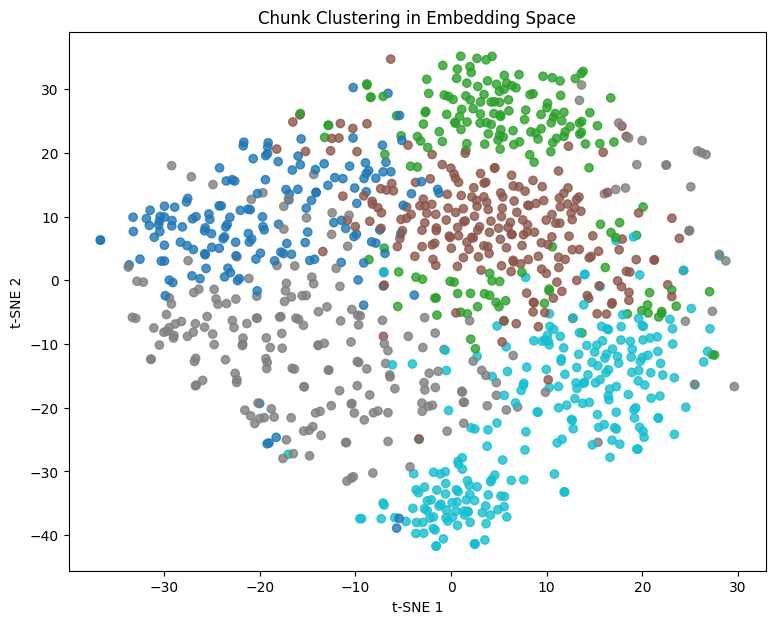

In [137]:
plt.figure(figsize=(9, 7))
scatter = plt.scatter(df_period["x_chunks"], df_period["y_chunks"], c=df_period["cluster_chunks"], cmap="tab10", alpha=0.8)
plt.title("Chunk Clustering in Embedding Space")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")


In [53]:
df_period.columns

Index(['uid', 'access_right', 'collections', 'countryCode', 'dataProviderCode',
       'excerpt', 'isOnFrontPage', 'is_content_available', 'is_olr', 'issue',
       'languageCode', 'locations_mentioned', 'mediaCode',
       'mediaPoliticalOrientation', 'mediaTopics', 'newsagencies_mentioned',
       'pages', 'periodicity', 'persons_mentioned', 'provinceCode',
       'publicationDate', 'relevance', 'title', 'topics', 'totalPages',
       'transcript', 'transcriptLength', 'type', 'year', 'title_embedding',
       'article_embedding', 'chunks', 'chunk_embedding', 'cluster', 'x', 'y'],
      dtype='object')

In [ ]:
# persons_mentioned

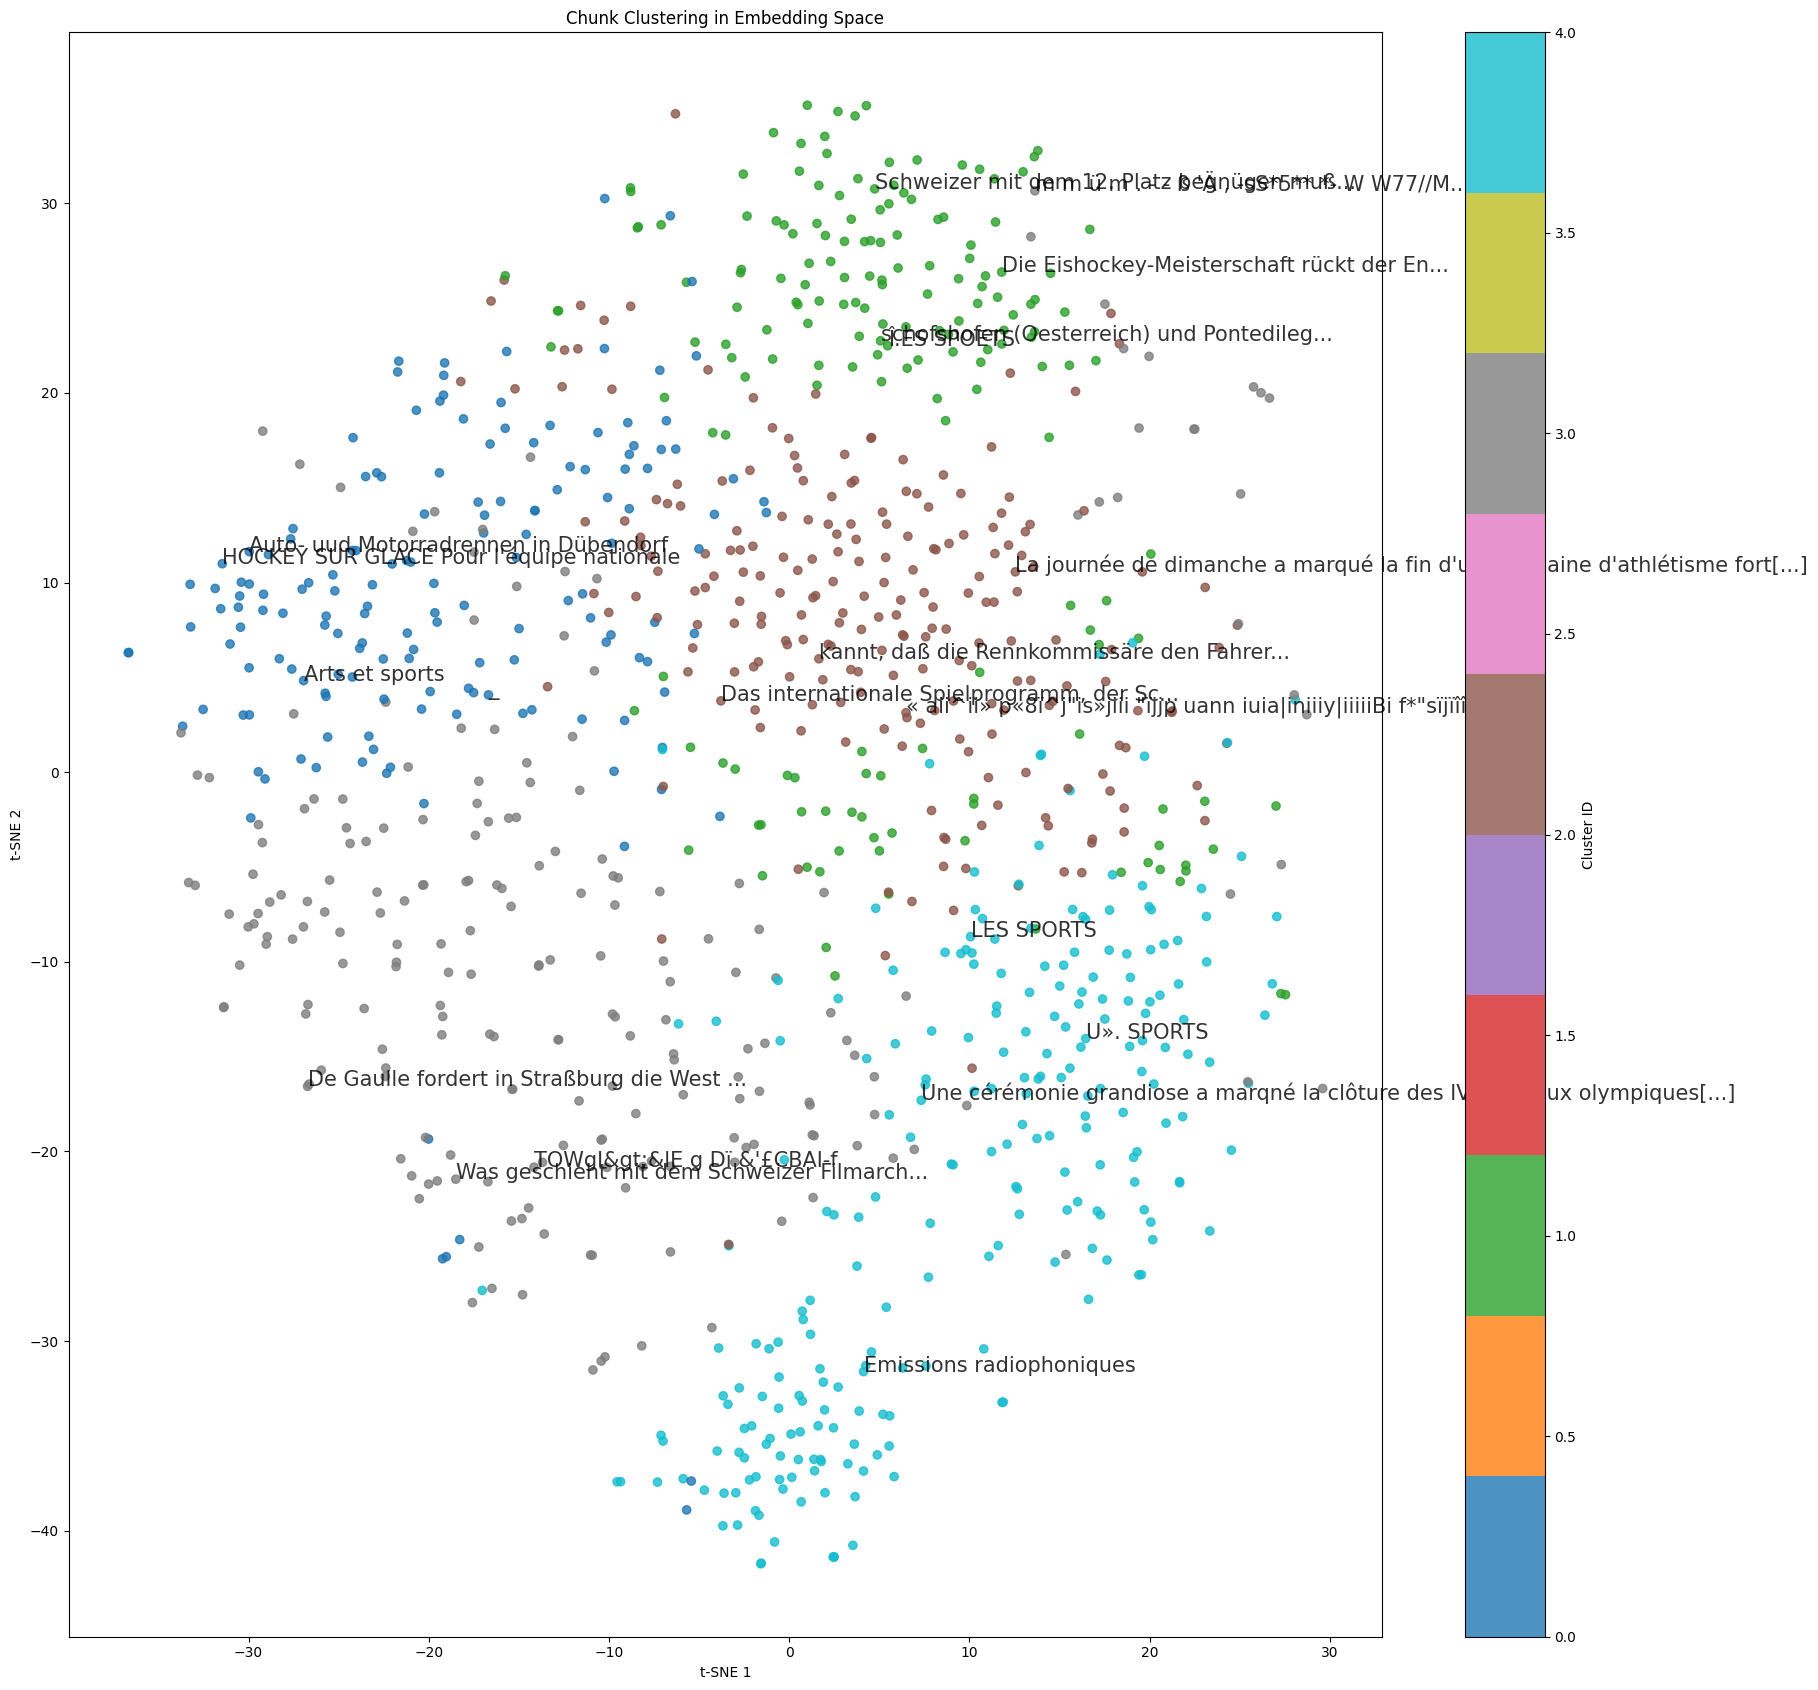

In [101]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(19, 17))
scatter = plt.scatter(df_period["x_chunks"], df_period["y_chunks"], c=df_period["cluster_chunks"], cmap="tab10", alpha=0.8)
plt.title("Chunk Clustering in Embedding Space")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

for cluster_id in df_period["cluster_chunks"].unique():
    sample = df_period[df_period["cluster_chunks"] == cluster_id].sample(4, random_state=42)
    for _, row in sample.iterrows():
        plt.text(row["x_chunks"], row["y_chunks"], row["title"], fontsize=15, alpha=0.8)

plt.colorbar(scatter, label="Cluster ID")
plt.tight_layout()
plt.show()

In [35]:
df_period.columns

Index(['uid', 'access_right', 'collections', 'countryCode', 'dataProviderCode',
       'excerpt', 'isOnFrontPage', 'is_content_available', 'is_olr', 'issue',
       'languageCode', 'locations_mentioned', 'mediaCode',
       'mediaPoliticalOrientation', 'mediaTopics', 'newsagencies_mentioned',
       'pages', 'periodicity', 'persons_mentioned', 'provinceCode',
       'publicationDate', 'relevance', 'title', 'topics', 'totalPages',
       'transcript', 'transcriptLength', 'type', 'year', 'title_embedding',
       'article_embedding', 'chunks', 'chunk_embedding', 'cluster', 'x', 'y'],
      dtype='object')

In [103]:
df_period.head(1)

uid  access_right  collections countryCode  \
0  EXP-1934-02-05-a-i0060           NaN          NaN          CH   

  dataProviderCode                                            excerpt  \
0              SNL  PING. PONG Championnat neuch√¢telois et jurassi...   

   isOnFrontPage  is_content_available  is_olr             issue  ...  \
0          False                   NaN    True  EXP-1934-02-05-a  ...   

  transcriptLength type  year  \
0             1486   ar  1934   

                                     title_embedding  \
0  [-0.0448267497, 0.0652769282, -0.1140181050000...   

                                   article_embedding  \
0  [-0.034329962000000006, 0.0653999299, -0.04998...   

                                              chunks  \
0  {'context': None, 'embedding': None, 'end_inde...   

                                     chunk_embedding cluster_chunks  x_chunks  \
0  [-0.0148247033, -0.0021938346, -0.044421799500...              3 -2.382715   

    y_chunks  
0 -19.789143  

[1 rows x 36 columns]

In [102]:
for _, item in df_period.iterrows():
    print(item.chunks)
        

{'context': None, 'embedding': None, 'end_index': 2539, 'id': 'chnk_3790073fa2c64672acde740b36132e20', 'start_index': 2507, 'text': 'Puis, sur une proposition de M. ', 'token_count': 9}
{'context': None, 'embedding': None, 'end_index': 4978, 'id': 'chnk_f021237318044296b9a3777f4eb313b6', 'start_index': 4823, 'text': '6. Eduard Reinalter ( St. Moritz) 5: 52. 7. Jean Dormond ( Villars) 5: 53, 8. Marcel von Allmon ( Scheidegg) 5: 55. 9. Daniel Girardet ( Z√ºrich) 5: 57, 4. ', 'token_count': 57}
{'context': None, 'embedding': None, 'end_index': 10076, 'id': 'chnk_e4f563dce98f43f5975c25d1e00fb019', 'start_index': 10048, 'text': 'Lohmann 50 km in 43: 59, 6. ', 'token_count': 11}
{'context': None, 'embedding': None, 'end_index': 4401, 'id': 'chnk_e0967c92091d47d78b5d9fba7018d703', 'start_index': 4301, 'text': '22 h. 15, Vari√©t√©s. 22 h. 45, Musique de danse. MUNSTER : 9 h. 30, Chant. 10 h ., Culte catholique. ', 'token_count': 38}
{'context': None, 'embedding': None, 'end_index': 636, 'id': 

In [74]:
df_period.iloc[640].chunks

{'context': None,
 'embedding': None,
 'end_index': 4195,
 'id': 'chnk_6b40cd8a66b047098edbd5b742658a24',
 'start_index': 3709,
 'text': 'Als vor dem Kriege das Turnen in den Achsenm√§chten immer offenkundiger zu einer politisch-propagandistischen Attraktion wurde, brachen die Schweizer Turner jeglichen internationalen Verkehr ab. Um so verwunderlicher ist es in der Tat, da√ü, wo doch heute im Osten das Turnen nur unter politischem ¬´ Schutz ¬ª Existenzberechtigung hat, die schweizerische Turnerschaft nicht wie vor dem Kriege die Konsequenzen zieht, ja sogar die Nationalmannschaft zu einem L√§nderkampf nach Budapest dele-',
 'token_count': 140}

{'context': None, 'embedding': None, 'end_index': 14014, 'id': 'chnk_21e71d10cd6e46ecaf83e0e68ff05d67', 'start_index': 13231, 'text': "Ivan. Ruttkay, Hongrie ; 14. Maskay, Canada. Le tournoi de hockey sur glace Le tournoi de hockey sur glace s'est poursuivi devant un nombreux public ; le match le plus int√©ressant de la journ√©e a √©t√© la rencontre Canada-Angleterre. Les Britanniques ont fourni une bonne partie et ont oppos√© une r√©sistance s√©v√®re aux joueurs d'tique. Dans le second match, les deux teams des Etats-Unis et de l'Italie se sont trouv√©s en pr√©sence. Ce match a √©t√© remport√© avec une facilit√© d√©risoire par les joueurs am√©ricains. Les Italiens ont un syst√®me de jeu tr√®s primitif, o√π le jeu d'√©quipe n'a pour ainsi dire pas dc part. Le maniement du puck est tr√®s mauvais ; aussi n'est-il pas √©tonnant que l'√©quipe dc l'A. H. A. ait pu obtenir un pareil score. Canada bat Angleterre, 3-0 (1-0, 1-0, 1-0). ", 'token_count': 245}

In [ ]:
# # let's go chunky!!

# chunks = []

# # COLUMN VARIABLES
# TEXT = 'transcript'

# print("Chunking text columns...")
# for idx, row in tqdm(df_period.iterrows(), total=len(df_period)):
#         text = str(row[TEXT])
#         if text.strip():
#           chunks.append(chunker.chunk(text))

# df_period['chunks'] = chunks
# df_period_chunked = df_period.explode('chunks')
# df_period_chunked_sample = df_period_chunked.sample(1000, random_state=32)
# tqdm.pandas()
# df_period_chunked_sample['chunk_embedding'] = df_period_chunked_sample['chunks'].progress_apply(lambda x: convert_embedding(embed_text(x.text,'text')))



In [ ]:
# df_period_chunked_sample.reset_index(drop=True).to_json('olympic-general-chunks-sample-embedded.json')

In [ ]:
# import torch
# from transformers import pipeline

# pipeline = pipeline(
#     task="text2text-generation",
#     model="google-t5/t5-base",
#     dtype=torch.float16,
#     device=0
# )
# pipeline("translate English to French: The weather is nice today.")

In [127]:
if EMBEDDING_LEVEL == 'chunk':
  df_period = pd.read_json('olympic-general-chunks-sample-embedded.json')
else:
  df_period = pd.read_json('olympic-general-embedded.json')
df_period = df_period[~df_period[f'{EMBEDDING_LEVEL}_embedding'].isnull()]


In [128]:
df_period.head()

uid  access_right  collections countryCode  \
0  EXP-1934-02-05-a-i0060           NaN          NaN          CH   
1  DTT-1942-01-15-a-i0036           NaN          NaN          CH   
2  DTT-1944-07-11-a-i0022           NaN          NaN          CH   
3  EXP-1935-08-17-a-i0071           NaN          NaN          CH   
4  EXP-1932-08-10-a-i0075           NaN          NaN          CH   

  dataProviderCode                                            excerpt  \
0              SNL  PING. PONG Championnat neuch√¢telois et jurassi...   
1           Migros  f Innere Kraft durch Winterferien Sportliche A...   
2           Migros  Wtr Mf * f ¬ª, j a fr \ ______^___ flRn Entschl...   
3              SNL  Emissions radiophoniques de samedi i-ixtrau au...   
4              SNL  Les jeux olympiques √† Los 4 ng _@ 8 √®s NATATIO...   

   isOnFrontPage  is_content_available  is_olr             issue  ...  \
0          False                   NaN    True  EXP-1934-02-05-a  ...   
1          False                   NaN    True  DTT-1942-01-15-a  ...   
2          False                   NaN    True  DTT-1944-07-11-a  ...   
3          False                   NaN    True  EXP-1935-08-17-a  ...   
4          False                   NaN    True  EXP-1932-08-10-a  ...   

                                              topics totalPages  \
0  tm-fr-all-v2.0_tp25_fr|0.14 tm-fr-all-v2.0_tp5...          1   
1  tm-de-all-v2.0_tp72_de|0.3 tm-de-all-v2.0_tp31...          1   
2  tm-de-all-v2.0_tp72_de|0.479 tm-de-all-v2.0_tp...          1   
3  tm-fr-all-v2.0_tp94_fr|0.656 tm-fr-all-v2.0_tp...          1   
4  tm-fr-all-v2.0_tp59_fr|0.427 tm-fr-all-v2.0_tp...          1   

                                          transcript transcriptLength type  \
0  PING. PONG Championnat neuch√¢telois et jurassi...             1486   ar   
1  f Innere Kraft durch Winterferien Sportliche A...             1386   ar   
2  Wtr Mf * f ¬ª, j a fr \ ______^___ flRn Entschl...             2809   ar   
3  Emissions radiophoniques de samedi i-ixtrau au...             1265   ar   
4  Les jeux olympiques √† Los 4 ng _@ 8 √®s NATATIO...              250   ar   

   year                                    title_embedding  \
0  1934  [-0.0448267497, 0.0652769282, -0.1140181050000...   
1  1942  [-0.1104533002, -0.022621709900000002, -0.0651...   
2  1944  [-0.0176250301, 0.019606109700000002, -0.01716...   
3  1935  [-0.0301703177, 0.10173373670000001, 0.0352418...   
4  1932  [-0.0633300692, 0.0661942735, -0.0548848510000...   

                                   article_embedding  \
0  [-0.034329962000000006, 0.0653999299, -0.04998...   
1  [-0.08136026560000001, 0.04792016, -0.02906009...   
2  [-0.0143499104, 0.09960938250000001, -0.018219...   
3  [-0.0717601776, 0.0403700955, -0.0155300386, -...   
4  [-0.0614200644, 0.037880037000000005, -0.03041...   

                                              chunks  \
0  {'context': None, 'embedding': None, 'end_inde...   
1  {'context': None, 'embedding': None, 'end_inde...   
2  {'context': None, 'embedding': None, 'end_inde...   
3  {'context': None, 'embedding': None, 'end_inde...   
4  {'context': None, 'embedding': None, 'end_inde...   

                                     chunk_embedding  
0  [-0.0148247033, -0.0021938346, -0.044421799500...  
1  [-0.0198970716, 0.0979307517, -0.0025794248, -...  
2  [-0.0134961661, 0.0940115601, -0.0134274578, 0...  
3  [-0.0786307007, 0.1233951375, -0.0469811521, -...  
4  [-0.052805684500000005, 0.0739009529, -0.06637...  

[5 rows x 33 columns]

In [130]:
df_period["locations_mentioned"] = df_period["locations_mentioned"].apply(
    lambda x: [loc.strip() for loc in x.split("|") if loc.strip()] if isinstance(x, str) else []
)

In [131]:
df_period.locations_mentioned

0      [Berne, Neuch√¢tel, Gen√®ve, baltent, Paris, Ess...
1      [Europa, Berlin, Lauberhorn‚ÄîWickibordh√ºtte, Da...
2      [Z√ºrich, 2. Litschi, Lohmann, Deutschlands, Aa...
3      [Neuch√¢tel, Neuch√¢tel, Suisse, MUNSTER, Zurich...
4      [Australie, France, Allemagne, Br√©sil, Hongrie...
                             ...                        
995    [Allemagne, Espagne, Europe, Autriche, Italie,...
996    [Suisse, Suisse, Suisse, Tch√©coslovaquie, Tch√©...
997    [Kantons Z√ºrich, Escher-Wy√ü-Platzes, Athen, Be...
998    [Sonntag Basel, Grasshoppers, Paris, wurde, To...
999    [Lausanne, Schweiz, Z√ºrich, Westschweiz, Eidge...
Name: locations_mentioned, Length: 1000, dtype: object

In [129]:
df_period["persons_mentioned"] = df_period["persons_mentioned"].apply(
    lambda x: [p.strip() for p in x.split("|") if p.strip()] if isinstance(x, str) else []
)

In [108]:
from itertools import chain

location_counts = (
    pd.Series(chain.from_iterable(df_period["locations_mentioned"].dropna()))
    .value_counts()
)

person_counts = (
    pd.Series(chain.from_iterable(df_period["persons_mentioned"].dropna()))
    .value_counts()
)

In [110]:
location_counts.head(20)

Suisse        800
France        568
Etats-Unis    436
Italie        389
Angleterre    343
Lausanne      341
Su√®de         326
Paris         274
Hongrie       267
Schweiz       255
Z√ºrich        249
Zurich        242
Neuch√¢tel     241
Finlande      238
Belgique      208
Danemark      197
Hollande      197
Berlin        188
Lugano        181
Bern          179
Name: count, dtype: int64

In [111]:
person_counts.head(20)

cpl                  52
H√¥gger               44
Nemeth               42
Ahlden               42
Alex Jany            38
Beethoven            38
Ljungreen            35
Marcel Hansenne      34
Mel Patton           31
Zatopeck             28
Volkmer              28
Bieler               26
Steuri               25
Oblt                 25
HOCKEY               24
sgt                  24
Karl Frei            23
Mac Lane             23
Am√©ricain Cochran    21
Bolliger             21
Name: count, dtype: int64

In [123]:
from collections import Counter
from itertools import chain

for cluster_id in sorted(df_period["cluster_chunks"].unique()):
    subset = df_period[df_period["cluster_chunks"] == cluster_id].dropna()
    # print(list(subset["locations_mentioned"]))
    # Compute entity frequencies
    locs = list(chain.from_iterable(subset["locations_mentioned"]))
    # pers = list(chain.from_iterable(
    #     subset["persons_mentioned"]
    # ))

In [152]:
import numpy as np

def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

In [162]:
cosine_similarity([[1, 2, 3]], [[1, 2, 3]])

array([[1.]])

In [141]:
df_period.head()

uid  access_right  collections countryCode  \
0  EXP-1934-02-05-a-i0060           NaN          NaN          CH   
1  DTT-1942-01-15-a-i0036           NaN          NaN          CH   
2  DTT-1944-07-11-a-i0022           NaN          NaN          CH   
3  EXP-1935-08-17-a-i0071           NaN          NaN          CH   
4  EXP-1932-08-10-a-i0075           NaN          NaN          CH   

  dataProviderCode                                            excerpt  \
0              SNL  PING. PONG Championnat neuch√¢telois et jurassi...   
1           Migros  f Innere Kraft durch Winterferien Sportliche A...   
2           Migros  Wtr Mf * f ¬ª, j a fr \ ______^___ flRn Entschl...   
3              SNL  Emissions radiophoniques de samedi i-ixtrau au...   
4              SNL  Les jeux olympiques √† Los 4 ng _@ 8 √®s NATATIO...   

   isOnFrontPage  is_content_available  is_olr             issue  ...  \
0          False                   NaN    True  EXP-1934-02-05-a  ...   
1          False                   NaN    True  DTT-1942-01-15-a  ...   
2          False                   NaN    True  DTT-1944-07-11-a  ...   
3          False                   NaN    True  EXP-1935-08-17-a  ...   
4          False                   NaN    True  EXP-1932-08-10-a  ...   

  transcriptLength type  year  \
0             1486   ar  1934   
1             1386   ar  1942   
2             2809   ar  1944   
3             1265   ar  1935   
4              250   ar  1932   

                                     title_embedding  \
0  [-0.0448267497, 0.0652769282, -0.1140181050000...   
1  [-0.1104533002, -0.022621709900000002, -0.0651...   
2  [-0.0176250301, 0.019606109700000002, -0.01716...   
3  [-0.0301703177, 0.10173373670000001, 0.0352418...   
4  [-0.0633300692, 0.0661942735, -0.0548848510000...   

                                   article_embedding  \
0  [-0.034329962000000006, 0.0653999299, -0.04998...   
1  [-0.08136026560000001, 0.04792016, -0.02906009...   
2  [-0.0143499104, 0.09960938250000001, -0.018219...   
3  [-0.0717601776, 0.0403700955, -0.0155300386, -...   
4  [-0.0614200644, 0.037880037000000005, -0.03041...   

                                              chunks  \
0  {'context': None, 'embedding': None, 'end_inde...   
1  {'context': None, 'embedding': None, 'end_inde...   
2  {'context': None, 'embedding': None, 'end_inde...   
3  {'context': None, 'embedding': None, 'end_inde...   
4  {'context': None, 'embedding': None, 'end_inde...   

                                     chunk_embedding cluster_chunks  \
0  [-0.0148247033, -0.0021938346, -0.044421799500...              3   
1  [-0.0198970716, 0.0979307517, -0.0025794248, -...              2   
2  [-0.0134961661, 0.0940115601, -0.0134274578, 0...              2   
3  [-0.0786307007, 0.1233951375, -0.0469811521, -...              4   
4  [-0.052805684500000005, 0.0739009529, -0.06637...              1   

    x_chunks   y_chunks  
0  -2.382715 -19.789143  
1  14.380722  -2.825704  
2  24.286926   1.524614  
3  -2.078850 -34.469189  
4   2.029038  -2.057715  

[5 rows x 36 columns]

In [166]:
df_period.columns

Index(['uid', 'access_right', 'collections', 'countryCode', 'dataProviderCode',
       'excerpt', 'isOnFrontPage', 'is_content_available', 'is_olr', 'issue',
       'languageCode', 'locations_mentioned', 'mediaCode',
       'mediaPoliticalOrientation', 'mediaTopics', 'newsagencies_mentioned',
       'pages', 'periodicity', 'persons_mentioned', 'provinceCode',
       'publicationDate', 'relevance', 'title', 'topics', 'totalPages',
       'transcript', 'transcriptLength', 'type', 'year', 'title_embedding',
       'article_embedding', 'chunks', 'chunk_embedding', 'cluster_chunks',
       'x_chunks', 'y_chunks'],
      dtype='object')

In [167]:
for cluster_id in sorted(df_period["cluster_chunks"].unique()):
    subset = df_period[df_period["cluster_chunks"] == cluster_id]#.dropna()

    locs = list(chain.from_iterable(subset["locations_mentioned"]))
    pers = list(chain.from_iterable(
        subset["persons_mentioned"]
    ))
    # print(locs)
    # print(pers)

    loc_counts = Counter(locs)
    per_counts = Counter(pers)

    # Print cluster header
    print(f"\nüåÄ Cluster {cluster_id} ‚Äî {len(subset)} articles")
    print("=" * 70)

    # Print sample transcripts
    for _, row in subset.sample(min(5, len(subset)), random_state=42).iterrows():
        transcript_preview = row["transcript"].strip().replace("\n", " ")
        title = row["title"]
        year = row["year"]
        print(f"   ‚Ä¢ {year} --- {title} - {transcript_preview[:120]}... ({row['transcriptLength']} chars)")

    # Print entity frequencies
    print("\nüìç Top locations:")
    for loc, count in loc_counts.most_common(5):
        print(f"   - {loc}: {count}")

    print("\nüë§ Top persons:")
    for per, count in per_counts.most_common(5):
        print(f"   - {per}: {count}")

    print("-" * 70)


üåÄ Cluster 0 ‚Äî 158 articles
   ‚Ä¢ 1947 --- Arts et sports - Arts et sports Le nombre croissant des comp√©titions sportives, le nombreux public qu'elles attirent et l'enthousiasme qu... (742 chars)
   ‚Ä¢ 1948 --- _ - _ In Kanton demonstrierten 20 000 chinesische Ru√üland entsendet als Beobachter eine Delegation zu den Olympischen Spiele... (335 chars)
   ‚Ä¢ 1939 --- HOCKEY SUR GLACE Pour l'√©quipe nationale - HOCKEY SUR GLACE Pour l'√©quipe nationale La ligue suisse a s√©lectionn√© vingt joueurs pour les matches militaires qui ser... (158 chars)
   ‚Ä¢ 1950 --- Auto- uud Motorradrennen in D√ºbendorf - Auto- uud Motorradrennen in D√ºbendorf ^ mrW ^^ wfJ 7 /^ KJm Die Motorradrennen seh. Pr√§chtiges Fr√ºhsommerwetter belohnte... (3007 chars)
   ‚Ä¢ 1936 --- Les sports de dimanche - Les sports de dimanche FOOTBALL L'ouverture du championnat suisse n'est plus √©loign√©. Aussi les clubs proc√®dent-ils √† l'... (411 chars)

üìç Top locations:
   - Suisse: 93
   - Paris: 53
   - Lausan

In [184]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Words to test
words = ["winterspiele", "olympics", "sommerspiele", "Moritz", "London", "Londres"]
# words = ["""The modern Olympic Games (Olympics; French: Jeux olympiques)[a][1] are the world's preeminent international sporting events. They feature summer and winter sports competitions in which thousands of athletes from around the world participate in a variety of competitions. The Olympic Games, open to both amateur and professional athletes, involves more than 200 teams, each team representing a sovereign state or territory. By default, the Games generally substitute for any world championships during the year in which they take place (however, each class usually maintains its own records).[2] The Olympics are staged every four years. Since 1994, they have alternated between the Summer and Winter Olympics every two years during the four-year Olympiad.[3][4] """]

# words = ["""The 1948 Summer Olympics, officially the Games of the XIV Olympiad and officially branded as London 1948, were an international multi-sport event held from 29 July to 14 August 1948 in London, United Kingdom. Following a twelve-year hiatus caused by the outbreak of World War II, these were the first Summer Olympics held since the 1936 Games in Berlin. The 1940 Olympic Games had been scheduled for Tokyo and then for Helsinki, while the 1944 Olympic Games had been provisionally planned for London. This was the second time London hosted the Olympic Games, having previously hosted them in 1908, making it the second city to host the Summer Olympics twice (after Paris). The Olympics would return again to London 64 years later in 2012, making London the first city to host the games thrice, and the only such city until Paris, who hosted their third games in 2024, and Los Angeles, who will host theirs in 2028. The 1948 Olympic Games were also the first of two summer Games held under the IOC presidency of Sigfrid Edstr√∂m. """]

# words = ["""The 1948 Winter Olympics, officially known as the V Olympic Winter Games (German: V. Olympische Winterspiele; French: Ves Jeux olympiques d'hiver; Italian: V Giochi olimpici invernali; Romansh: V Gieus olimpics d'enviern) and commonly known as St. Moritz 1948 (French: Saint-Moritz 1948; Romansh: San Murezzan 1948), were a winter multi-sport event held from 30 January to 8 February 1948 in St. Moritz, Switzerland. The Games were the first to be celebrated after World War II; it had been twelve years since the last Winter Games in 1936. """]

# words = ["""Titanic was a British ocean liner that sank in the early hours of 15 April 1912 as a result of striking an iceberg on her maiden voyage from Southampton, England, to New York City, United States. Of the estimated 2,224 passengers and crew aboard, approximately 1,500 died (estimates vary), making the incident one of the deadliest peacetime sinkings of a single ship.[4] Titanic, operated by White Star Line, carried some of the wealthiest people in the world, as well as hundreds of emigrants from the British Isles, Scandinavia, and elsewhere in Europe who were seeking a new life in the United States and Canada. The disaster drew public attention, spurred major changes in maritime safety regulations, and inspired a lasting legacy in popular culture. It was the second time White Star Line had lost a ship on her maiden voyage, the first being RMS Tayleur in 1854.[5]"""]

for word in words:
    print(f"\nüèÖ Word: '{word}'")
    print("=" * 70)
    
    # Embed the word once
    word_emb_b64 = embed_text(word, target="text")
    word_emb = np.array(convert_embedding(word_emb_b64)).reshape(1, -1)
    
    results = []
    
    for cluster_id in sorted(df_period["cluster_chunks"].dropna().unique()):
        subset = df_period[df_period["cluster_chunks"] == cluster_id].copy()
        valid_rows = []
        
        for _, row in subset.iterrows():
            try:
                emb = np.array(row["chunk_embedding"], dtype=float).reshape(1, -1)
                sim = cosine_similarity(emb, word_emb)[0][0]

                sim_check = cosine_similarity(word_emb, word_emb)[0][0]
                # print('!!!!!!', sim_check)
                valid_rows.append(sim)
            except Exception:
                continue
        
        mean_sim = np.mean(valid_rows) if valid_rows else np.nan
        results.append((cluster_id, mean_sim, len(valid_rows)))

    
    # Convert results to DataFrame and sort
    df_sim = pd.DataFrame(results, columns=["cluster_id", "mean_similarity", "num_samples"])
    df_sim = df_sim.sort_values("mean_similarity", ascending=False)
    
    # Print top 3 clusters with excerpts
    for _, row in df_sim.head(5).iterrows():
        cid = int(row['cluster_id'])
        print(f"\nüì¶ Cluster {cid:>3}: "
              f"Mean similarity = {row['mean_similarity']:.4f} "
              f"({int(row['num_samples'])} samples)")
        print("-" * 70)
        
        # Pick top 3 similar rows from this cluster
        subset = df_period[df_period["cluster_chunks"] == cid].copy()
        subset["similarity"] = subset["chunk_embedding"].apply(
            lambda emb: cosine_similarity(np.array(emb, dtype=float).reshape(1, -1), word_emb)[0][0]
        )
        subset = subset.sort_values("similarity", ascending=False).head(3)
        
        # Print transcript excerpts
        for i, r in subset.iterrows():
            excerpt = r["transcript"].strip().replace("\n", " ")[:1000]
            uid = r["uid"]
            print(f"   ‚Ä¢ {uid} -- {excerpt}... (sim={r['similarity']:.4f}, len={r['transcriptLength']})")
        print("-" * 70)


üèÖ Word: 'winterspiele'

üì¶ Cluster   0: Mean similarity = 0.4942 (158 samples)
----------------------------------------------------------------------
   ‚Ä¢ DTT-1948-02-16-a-i0077 -- Die Olympischen Sommerspiele in London Unterkunft und Verpflegung Von unserem Londoner Sport-Korrespondenten G-. B. Es ist noch verh√§ltnism√§√üig still um die Vorbereitung der Olympischen Sommerspiele in London. Das bedeutet, aber keineswegs, da√ü nicht gearbeitet wird; es wird sogar sehr fest, gearbeitet, und es ist jetzt, schon sicher, da√ü die Organisation der Spiele musterg√ºltig sein wird. Gro√übritannien betrachtet es als eine Ehre, den Sportlern aus allen Herren L√§ndern so viele W√ºnsche wie m√∂glich zu erf√ºllen und ihnen den Anla√ü zu einem unverge√ülichen Erlebnis zu machen. Man kann sich leicht vorstellen, da√ü vor allem die Unterbringung der Athleten gro√üe Schwierigkeiten mit sich bringt. Ihr Berichterstatter entschlo√ü sich deshalb, den Mann, der f√ºr die Placierung der Wettk√§mpfer u

In [142]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 4))
# plt.bar(df_sim["cluster_id"], df_sim["mean_similarity"])
# plt.title("Mean Similarity to 'Olympics' Embedding per Cluster")
# plt.xlabel("Cluster ID")
# plt.ylabel("Cosine Similarity")
# plt.show()

NameError: name 'olympics_emb_b64' is not defined

# Fin